In [78]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.integrate import quad
import math
%matplotlib inline
text_size = 20


# Problem 3
(a) Using the UV luminosity function determinations (Schechter function with M*, $\phi_*$, $\alpha$) from the literature and your calibration of the FUV SFR indicator in Problem Set 5, measure the Cosmic SFG (i.e., redshift vs. SFR density) from z ~ 0-8. You may find 5.1 of Madau & Dickinson 2014 and/or 8 of Finkelstein et al. 2015 to be useful in this exercise. Clearly indicate references for your UV luminosity function parameters. How does your determination compare to that of Madau & Dickinson (2014) and/or Finkelstein et al (2015)? What might account for any differences?

Schechter Parameters 

z    $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ M^*_{UV} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \phi^*(/10^3)  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \   \alpha \ \ \ \  \ \ \ \  \ \ \ \ \ \ \ \ \ \ $   reference

0.2-0.4 ..... -18.3 +/- 0.1 ....... 6.91 +/- 1.00 ..... -1.17 +/- 0.05 ..... Cucciati et al. 2014 

1.0-1.2 ..... -19.0 +/- 0.2 ....... 7.43 +/- 1.11 ..... -0.91 +/- 0.16 ..... Cucciati et al. 2014 

1.7-2.5 ..... -20.4 +/- 0.1 ....... 3.37 +/- 0.24 ..... -1.30 ................... Cucciati et al. 2014 

2.5-3.5 ..... -21.4 +/- 0.1 ....... 0.86 +/- 0.05 ..... -1.50 ................... Cucciati et al. 2014

4 .............. -20.98 +/- 0.10 ... 1.3 +/- 0.2 ......... -1.73 +/- 0.05 ..... Bouwens et al. 2007

5 .............. -20.60 +/- 0.23 ... 1.4 +/- 0.6 ......... -1.79 +/- 0.12 ..... Bouwens et al. 2012a

6 .............. -20.37 +/- 0.30 ... 1.4 +/- 0.8 ......... -1.73 +/- 0.20 ..... Bouwens et al. 2012a

7 .............. -20.14 +/- 0.26 ... 0.86 +/- 0.55 ...... -2.01 +/- 0.21 ..... Bouwens et al. 2012a

8 .............. -20.10 +/- 0.52 ... 0.59 +/- 0.70 ...... -1.91 +/- 0.32 ..... Bouwens et al. 2012a


In [74]:
#various Schechter function parameters for z ranging from 0.3 to 8
z = np.array([0.3, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
M_star = np.array([-18.3, -19.0, -20.4, -21.4, -20.98, -20.60, -20.37, -20.14, -20.10])
M_star_err = np.array([0.1, 0.2, 0.1, 0.1, 0.1, 0.23, 0.3, 0.26, 0.52])
Phi_star = np.array([6.91e-3, 7.43e-3, 3.37e-3, 0.86e-3, 1.3e-3, 1.4e-3, 1.4e-3, 0.86e-3, 0.59e-3])
Phi_star_err = np.array([1e-3, 1.11e-3, 0.24e-3, 0.05e-3, 0.2e-3, 0.6e-3, 0.8e-3, 0.55e-3, 0.7e-3])
Alpha = np.array([-1.17, -0.91, -1.30, -1.50, -1.73, -1.79, -1.73, -2.01, -1.91])

In [57]:
#convert M* into L*
pc = 3.08568025e18 #parsec in cm
m_ab0 = -2.5*np.log10(3631e-23) # AB magnitude zero point
const = 4.* np.pi*(10.*pc)**2
F_star = 10.**(-0.4*(M_star + m_ab0)) 
L_star = const * F_star

In [130]:
#define ranges to integrate Schechter function
lum_min = 0.03 #ergs per second per Hz
lum_max = np.inf #ergs per second per Hz
lum_int = []
lum_int_err = []
#integrate L*Schechter function to get ergs/s/Mpc^3 using d(L/L*)
for i in range(len(Alpha)):
    #lum = lambda L: L*Phi_star[i]*((L/L_star[i])**Alpha[i])*np.exp(-L/L_star[i])
    lum = lambda x: ((x)**(Alpha[i]+1.))*np.exp(-x)
    luminosity_int = quad(lum, lum_min, lum_max)
    luminosity_int, luminosity_err = luminosity_int
    lum_int.append(luminosity_int)
    lum_int_err.append(luminosity_err)
lum_int = np.asarray(lum_int*Phi_star*L_star)
lum_int_err = np.asarray(lum_int_err*Phi_star*L_star)
print lum_int

[  6.69511716e+25   1.20243523e+26   2.49050336e+26   1.93915948e+26
   2.66672810e+26   2.21061314e+26   1.63743256e+26   1.28054447e+26
   7.11672284e+25]


Now we use the equation from Kennicutt & Evans 2012 to convert the FUV luminosity into a star formation rate using the equation below
$$log(\dot{M_*} (M_\odot yr^{-1}))  = log (L_{FUV}) - log(C_{FUV})$$
where $log(C_{FUV})$ is 43.35 and $L_{FUV}$ is in units ergs/s, or $\nu L_\nu$
Far UV centers at around 160 nm or 1.874 * $10^{15}$Hz.

In [131]:
#convert Lnu to nuLnu and find SFR
nu = 1.874e15
log_c_fuv = 43.35
#find log(SFR) from kennicutt eqn
log_sfr = np.log10(nu*lum_int) - log_c_fuv
#add in quadrature errors on phi*, L*, lum to get SFR errors
log_sfr_err = np.sqrt((lum_int_err/(lum_int*np.log(10)))**2+(Phi_star_err/(Phi_star*np.log(10)))**2 + ((M_star_err*.4)**2))

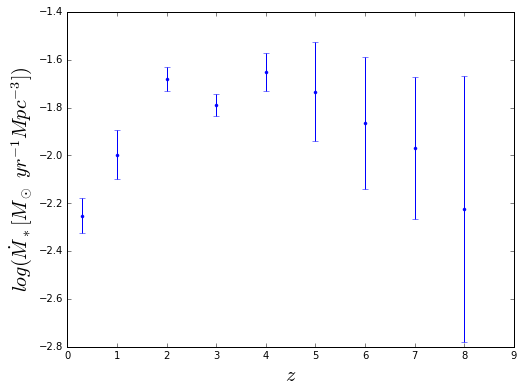

In [129]:
#plot log(SFR) vs redshift
fig, ax = plt.subplots(figsize = (8,6))
ax.errorbar(z,log_sfr, yerr = log_sfr_err, fmt = '.')
ax.set_ylabel('$log(\dot{M}_*[M_\odot \ yr^{-1}Mpc^{-3}])$', fontsize = text_size)
ax.set_xlabel('$z$', fontsize = text_size)
ax.set_xlim(0,9)
plt.show()

# Problem 1(b)
Using your results of part (a) and emcee, fit Equation 7 from Finkelstein et al. 2015 to your cosmic SFH data. Generate the usual plots for model fitting. How do your results compare to those presented in Madau & Dickinson 2014 and/or Finkelstein et al. 2015? What might be the source of any difference?

Now we are going to use the following function to the SFR history, using the following equation from Madau & Finkelstein 2015,
$$\phi(z) = A \frac{(1+z)^\alpha}{1 + [(1+z)/B]^\gamma} $$

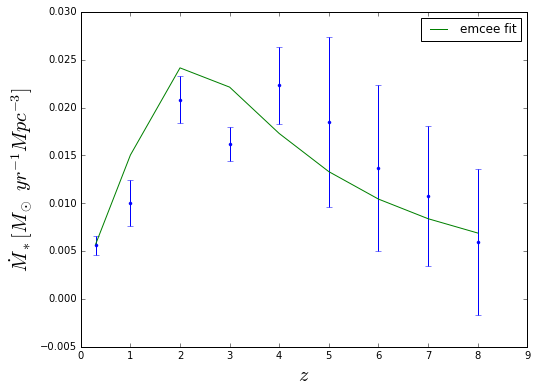

In [128]:
#convert log(sfr) to SFR, also recompute the errors
sfr = 10**log_sfr
sfr_err = sfr*np.log(10)*log_sfr_err

#test emcee output
emcee_fit = []
#emcee values
A_e = 0.003
B_e = 2.916
alpha_e = 2.587
gamma_e = 4.298
for i in range(len(z)):
    emcee_fit.append(A_e*((1+z[i])**alpha_e)/(1+((1+z[i])/B_e)**gamma_e))

fig, ax1 = plt.subplots(figsize = (8,6))
ax1.errorbar(z,sfr, yerr = sfr_err, fmt = '.')
ax1.plot(z, emcee_fit, color = 'green', label = 'emcee fit')
ax1.set_ylabel('$\dot{M}_*[M_\odot \ yr^{-1} Mpc^{-3}]$', fontsize = text_size)
ax1.set_xlabel('$z$', fontsize = text_size)
ax1.set_xlim(0,9)
plt.legend()
plt.show()

In [119]:
#define functions for emcee

def ln_like(theta, z, sfr, sfr_err):
    """Likelihood function that aims to minimize the difference between the SFR and the 
    test SFR functional fit."""
    alpha, gamma, A, B = theta
    sfr_test = A*((1+z)**alpha)/(1+((1+z)/B)**gamma)
    #phi_test = 0.4*np.log(10.0)*10**log_phi_star*10**(-0.4*(mags - m_star)*(alpha + 1))*np.exp(-10**(-0.4*(mags-m_star)))
    #phi_err = np.asarray(phi_err)
    return -0.5*np.sum(((sfr_test-sfr)/sfr_err)**2.0+np.log(2.0*np.pi*sfr_err**2.0))

def lnprior(theta):
    """Prior function that assumed top hat prior"""
    alpha, gamma, A, B = theta
    if 1.0 < alpha < 4.5 and 3.0 < gamma < 6.0 and 0.0 < A < 0.06 and 1.5 < B < 4.0: 
        return 0.0 
    return -np.inf

def lnprob(theta, z, sfr, sfr_err):
    """Here I combine the prior and the likelihood function in log space to get the probability"""
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp +  ln_like(theta, z, sfr, sfr_err)  

In [111]:
#initialize emcee sampler for the 4 parameters in the function
n_walkers = 300
ndim = 4
initial = np.array([np.random.rand(ndim) for i in range(n_walkers)])
initial[:,0] = initial[:,0]*(1e-2)+2.7
initial[:,1] = initial[:,1]*(1e-2)+5.5
initial[:,2] = initial[:,2]*(1e-3)+ 0.01
initial[:,3] = initial[:,3]*(1e-2)+2.9
sampler = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=[z, sfr, sfr_err])

#burn in, then reset sampler
pos, prob, state = sampler.run_mcmc(initial, 1000)
sampler.reset()
sampler.run_mcmc(pos, 1000, rstate0 = state)

(array([[  2.67090701e+00,   4.24355910e+00,   1.87571357e-03,
           3.19526456e+00],
        [  3.75845529e+00,   4.01166758e+00,   1.87267186e-03,
           1.95713597e+00],
        [  1.60418891e+00,   4.06868058e+00,   4.37496113e-03,
           3.87611784e+00],
        ..., 
        [  4.27704881e+00,   4.74026669e+00,   1.77243778e-03,
           1.86892209e+00],
        [  4.00081600e+00,   4.30004204e+00,   2.52657390e-03,
           1.72239479e+00],
        [  2.57385440e+00,   4.29283553e+00,   2.29028614e-03,
           3.05734637e+00]]),
 array([ 35.15054672,  37.05566987,  36.97850644,  35.9086788 ,
         37.06171841,  35.35582834,  32.15515965,  35.21839727,
         35.87720005,  36.26925521,  37.40853502,  37.53070261,
         35.96720949,  36.72715587,  37.54030423,  37.31872056,
         37.14352266,  37.34711066,  35.98612662,  36.08567083,
         37.08434859,  36.69780396,  37.44183432,  37.16339804,
         37.44732253,  37.0342522 ,  37.16549559,  37.

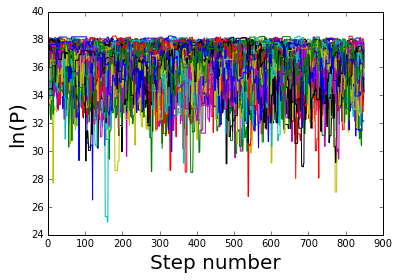

In [120]:
plt.figure(2)
[plt.plot(sampler.lnprobability[i,150:]) for i in range(100)]
plt.xlabel(r'Step number', fontsize = text_size)
plt.ylabel(r'ln(P)', fontsize = text_size)
plt.show()

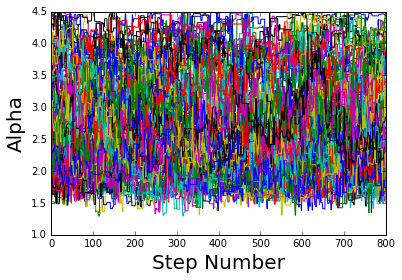

In [121]:
plt.figure(3)
[plt.plot(sampler.chain[i,200:,0]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Alpha', fontsize = text_size)

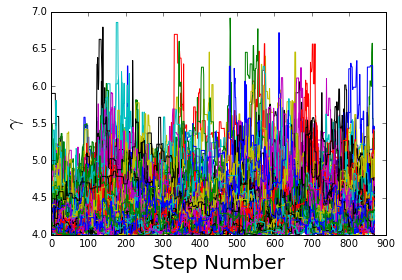

In [122]:
plt.figure(4)
[plt.plot(sampler.chain[i,130:,1]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'$\gamma$', fontsize = text_size)

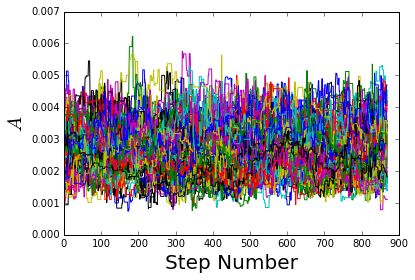

In [115]:
plt.figure(5)
[plt.plot(sampler.chain[i,130:,2]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'$A$', fontsize = text_size)

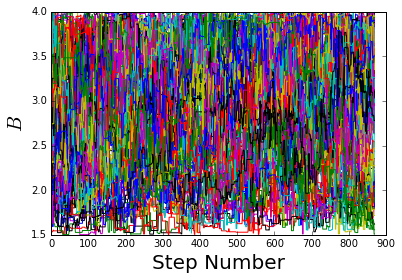

In [116]:
plt.figure(6)
[plt.plot(sampler.chain[i,130:,3]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'$B$', fontsize = text_size)

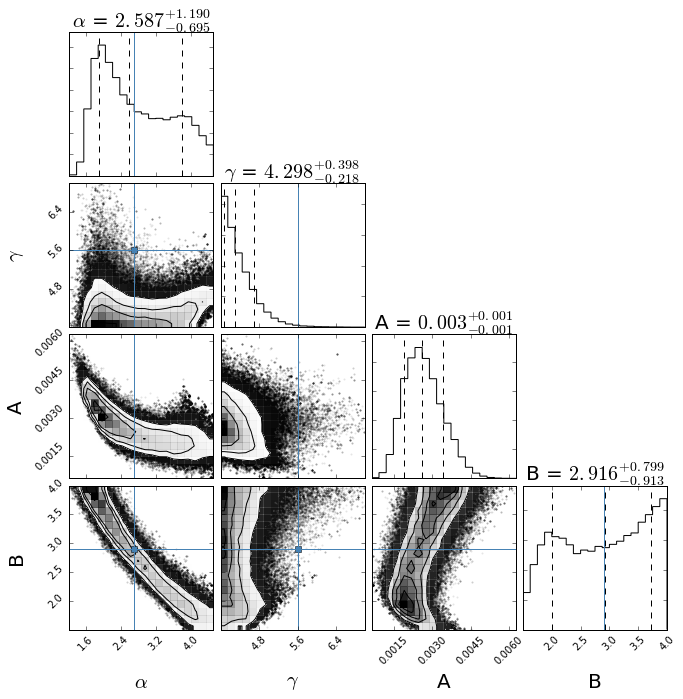

In [123]:
corner_plot = corner.corner(sampler.flatchain[100:,:], labels = [r'$\alpha$',r'$\gamma$', 'A','B'], show_titles = True,\
              plot_contours = True, quantiles = [0.16,0.5,0.84], truths = [2.7, 5.6, 0.015,2.9],
                           label_kwargs={"fontsize": 20}, title_kwargs={"fontsize": 20},title_fmt = '.3f')
corner_plot.show()

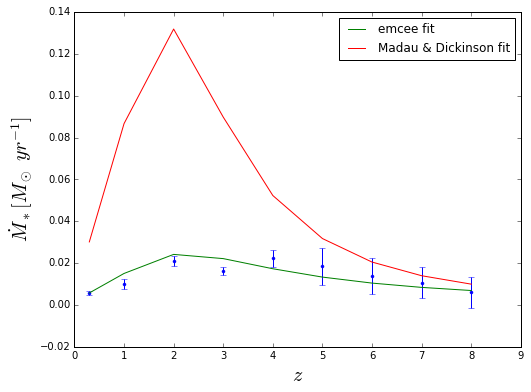

In [127]:
#compare to Madau and Dickinson 2014
#A~0.015, B ~ 2.9, alpha ~ 2.7, gamma ~ 5.6
A_md = 0.015
B_md = 2.9
alpha_md = 2.7
gamma_md = 5.6
madau_fit = []
for i in range(len(z)):
    madau_fit.append(A_md*((1+z[i])**alpha_md)/(1+((1+z[i])/B_md)**gamma_md))

#plot comparison between Madau & Dickinson 2015 and my emcee best fit
fig, ax2 = plt.subplots(figsize = (8,6))
ax2.errorbar(z,sfr, yerr = sfr_err, fmt = '.')
ax2.plot(z, emcee_fit, color = 'green', label = 'emcee fit')
ax2.plot(z, madau_fit, color = 'red', label = 'Madau & Dickinson fit')
ax2.set_ylabel('$\dot{M}_*[M_\odot \ yr^{-1}]$', fontsize = text_size)
ax2.set_xlabel('$z$', fontsize = text_size)
ax2.set_xlim(0,9)
plt.legend()
plt.show()

The Madau & Dickinson 2014 fit to the SFH is significantly more peaked at z = ~1-4 than my own emcee fit. This may have to do with the fact that different data was used with different methods of measuring the data.